This notebook makes an evaluation of DenseNet169 Neural Networks for automatic classification of common maternal fetal ultrasound planes

Work done by :  Zarrouq Soukaina

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#download data to google drive
!wget https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1 /content/drive/MyDrive/DL
!mkdir data
!unzip FETAL_PLANES_ZENODO.zip?download=1 -d /content/drive/MyDrive/DL/data

--2022-02-17 09:22:40--  https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2088522169 (1.9G) [application/octet-stream]
Saving to: ‘FETAL_PLANES_ZENODO.zip?download=1.2’

FETAL_PLANES_ZENODO 100%[===================>]   1.94G  4.75MB/s    in 7m 32s  

2022-02-17 09:30:13 (4.40 MB/s) - ‘FETAL_PLANES_ZENODO.zip?download=1.2’ saved [2088522169/2088522169]

/content/drive/MyDrive/DL: Scheme missing.
FINISHED --2022-02-17 09:30:13--
Total wall clock time: 7m 34s
Downloaded: 1 files, 1.9G in 7m 32s (4.40 MB/s)
mkdir: cannot create directory ‘data’: File exists
Archive:  FETAL_PLANES_ZENODO.zip?download=1
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfil

In [3]:
#read excel file that contains labels
df = pd.read_excel("/content/drive/MyDrive/DL/data/FETAL_PLANES_DB_data.xlsx")

In [4]:
#define columns names
df = df.rename(columns={'Image_name': 'Image', 'Plane': 'label'})
df['Image'] = df['Image'].apply(lambda x: x.replace(x, '/content/drive/MyDrive/DL/data/Images/'+x+'.png'))

In [5]:
#show first 5 rows
df.head()

,Image,Patient_num,label,Brain_plane,Operator,US_Machine,Train
0,/content/drive/MyDrive/DL/data/Images/Patient0...,1,Other,Not A Brain,Other,Aloka,1
1,/content/drive/MyDrive/DL/data/Images/Patient0...,1,Other,Not A Brain,Other,Aloka,1
2,/content/drive/MyDrive/DL/data/Images/Patient0...,1,Other,Not A Brain,Other,Aloka,1
3,/content/drive/MyDrive/DL/data/Images/Patient0...,1,Other,Not A Brain,Other,Aloka,1
4,/content/drive/MyDrive/DL/data/Images/Patient0...,1,Other,Not A Brain,Other,Aloka,1


In [6]:
#split data to train and test data
df_train = df[df['Train ']==1][['Image', 'label']]
df_test = df[df['Train ']==0][['Image', 'label']]

In [7]:
#show train data shape
df_train.shape

(7129, 2)

In [14]:
print('training data is {0:.2f}% of the whole dataset.'.format(7129/(7129+5271)*100))

training data is 57.49% of the whole dataset.


In [15]:
#define training data generator
batch_size = 32
#scaling images between 0 and 1
datagen = ImageDataGenerator(rescale=1./255,)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="Image",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)


Found 7129 validated image filenames belonging to 6 classes.


In [16]:
#define test data generator
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="Image",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

Found 5271 validated image filenames belonging to 6 classes.


In [20]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization

#define Densenet model
model = Sequential()

densenet= tf.keras.applications.densenet.DenseNet169(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling=None,
                   #output classes
                   classes=6,
                   weights='imagenet'
                   )

#woring with initial weights
for layer in densenet.layers:
        layer.trainable=False

#Use a Learning Rate Schedule
reduce_learning_rate = ReduceLROnPlateau(monitor='val_acc',
                                         factor=0.001,
                                         patience=5,
                                         cooldown=1,
                                         min_lr=0.000001,
                                         verbose=1)

#Stop training when accuracy has stopped improving                                       
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                          baseline=None, restore_best_weights=True)

callbacks = [reduce_learning_rate, earlystop]


model.add(densenet)

model.add(GlobalAveragePooling2D())

#adding top layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

model.summary()

51888128/51877672 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                       

In [24]:
#compile model
callbacks = [reduce_learning_rate, earlystop]
model.compile(optimizer=Adam(learning_rate=0.07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#save history of model
history = model.fit(train_generator, 
                    validation_data=test_generator,
                    epochs=40)

Epoch 1/40
223/223 [==============================] - 431s 2s/step - loss: 0.4462 - accuracy: 0.8450 - val_loss: 0.6833 - val_accuracy: 0.7621
Epoch 2/40
223/223 [==============================] - 150s 675ms/step - loss: 0.3821 - accuracy: 0.8652 - val_loss: 0.5829 - val_accuracy: 0.7898
Epoch 3/40
223/223 [==============================] - 144s 648ms/step - loss: 0.4100 - accuracy: 0.8620 - val_loss: 0.7498 - val_accuracy: 0.7858
Epoch 4/40
223/223 [==============================] - 145s 649ms/step - loss: 0.4515 - accuracy: 0.8573 - val_loss: 0.4671 - val_accuracy: 0.8590
Epoch 5/40
223/223 [==============================] - 142s 638ms/step - loss: 0.3729 - accuracy: 0.8732 - val_loss: 0.4497 - val_accuracy: 0.8461
Epoch 6/40
223/223 [==============================] - 142s 635ms/step - loss: 0.3206 - accuracy: 0.8832 - val_loss: 0.6077 - val_accuracy: 0.8313
Epoch 7/40
223/223 [==============================] - 145s 650ms/step - loss: 0.3870 - accuracy: 0.8711 - val_loss: 0.5091 - va

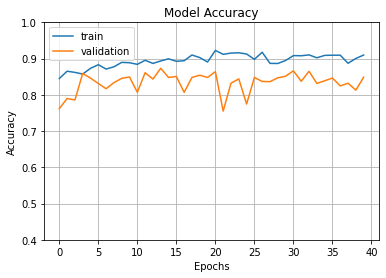

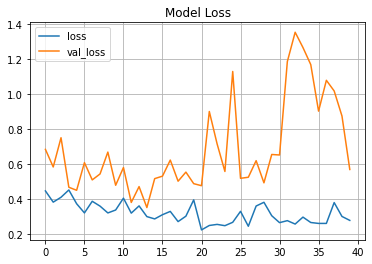

In [25]:
#plot modal accuracy  and model loss
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)

plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.grid()
plt.title('Model Loss')
plt.legend()

In [ ]:
#Conclusion
the model has shown a validation accuracy of 0.84 and a training accuracy of 0.9098 which shows that there is room for overfitting that needs to be addressed
also even after using 40 epochs the model hasn't improved and kept its accuracy in the range of 0.84
unfortunately it was difficult to work with the standard plan of Google Colab since it hinders training and experimenting with modals, architectures
and hyperparameter tuning
